# AMATERASU tutorial

In this notebook, I will briefly explain how AMATERASU works and how to run it.

## What is AMATERASU?

AMATERASU (AutoMATic Equivalent-width Retrieval for Activity Signal Unveiling) is a simple Python tool to check for periods in spectral activity indices similar to an input period. This way, by running AMATERASU for a spectral line, the user can see if the input period may be correlated with activity. It's important to note that AMATERASU follows a methodology similar to the one described in Gomes da Silva et al. 2025 (in prep) and is heavily inspired by ACTIN2.

## How does AMATERASU work?

AMATERASU computes the equivalent width (EW) of a spectral line in a normalization independent way, by using the 90th percentile of the flux in a given window as the continuum level. It computes the EW for an array of bandpasses, going from 0.1 $\AA$ up to a user defined width.

This way, the input includes the spectral line center, bandpass width and a window that includes both the line and some continuum. By default, the flux is interpolated inside the window, with a step similar to the original spectrum's step. The maximum bandpass and the interpolation window can be given manually or automatically. Automatically, the spectra are coadded and then the code uses the find_peaks function of scipy to find spectral lines in a given order and then retrieves the FWHM of the closest line to be studied (threshold of 0.1 A). The bandpass window is a multiple (rounded) of the FWHM retrieved (by default 4 times) and the interpolation window is double that (8 times the FWHM).

Having retrieved a time series of EWs measurements for a given bandpass, AMATERASU cleans the data by 3-sigma sequential clipping and binning the data by night. 

Finally, AMATERASU runs GLS periodograms (with a bunch of technicalities) and if the significant peak with most power is similar to the tested/input period, the program warns the user.

The user can choose one of the predefined indices in the ``ind_table.csv`` table or define a new indice.

Accepts a list of input periods and a list of lines to analyse.

Accepts both 1D and 2D spectra.

Output options:
    - Standard: warns if some input period was detect, in which line and with which FAP. Prints and saves a dataframe.
    - Full: saves all analysis data in a directory.

## Caveats and future upgrades

Caveats:
- AMATERASU was tested using NIRPS spectra only, so the predefined indices are NIR lines.
- AMATERASU was only tested with spectral lines that were more or less simmetrical and with a decent depth, so spectral lines like He I 10830 $\AA$ or Paschen $\beta$ were not considered.

Future upgrades:
- Include option to convert the wavelength to RV space.
- Option to include a known activity indice to compute correlations in function of central bandpass and return bandpass that maximizes correlation (positive or negative).

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, tqdm
from scipy.interpolate import interp1d
from specutils.manipulation import SplineInterpolatedResampler
from specutils import Spectrum1D #type: ignore
from astropy.nddata import StdDevUncertainty #type: ignore
import astropy.units as u #type: ignore
from astropy.io import fits
from scipy.signal import find_peaks

from SpecFunc import SpecFunc
SpecFunc = SpecFunc()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from AMATERASU import AMATERASU

The indice table contains 11 spectral lines predefined: 3 of K I, 3 of Ti I, 2 of Al I, 2 of Mn I and 1 of Fe I. The interpolation windows were defined as double the maximum EW window, but this is not mandatory.

In [2]:
ind_table = pd.read_csv("ind_table.csv")
ind_table

,ln_id,ln_ctr,ln_win,interp_win
0,AlIa,13127.011,5.0,10
1,AlIb,13154.345,5.0,10
2,FeI,11693.408,2.5,5
3,KIa,11772.862,2.0,4
4,KIb,12435.647,5.0,10
5,KIc,12525.544,5.0,10
6,MnIa,12903.289,2.5,5
7,MnIb,13322.609,2.0,4
8,TiIa,10498.989,1.5,3
9,TiIb,12825.181,1.5,3


Let's run AMATERASU for the star GJ 581 and the spectral line K I (c). The input period will be a literature rotation period value, the tolerance will be 10% of the aforementioned value and the FAP threshold for detection is 0.1%.

To run AMATERASU I also need to give the files (spectra) paths, the star ID, the name of the activity indice, the path to save some plots, and other parameters that were omitted in this tutorial.

In [ ]:
star = "GJ551"
_, files = SpecFunc._gather_spectra(star_name=star, instrument="NIRPS",type="2d")

spectra_observations = []; bjd_observations = np.zeros((len(files)))

for i, file in enumerate(files):
    spectrum_raw, header_raw = SpecFunc._Read(file, mode="vac")
    spectrum, header = SpecFunc._RV_correction(spectrum_raw, header_raw)
    spectra_observations.append([spectrum["wave"], spectrum["flux"], spectrum["flux_error"]])
    bjd_observations[i] = header["bjd"]

spectra_observations = np.array(spectra_observations, dtype=object) 
spectra_observations.shape

(137, 3, 71, 4084)

: 

## Interpolation tests

In [4]:
indice = "KIc"

ind_table = pd.read_csv("ind_table.csv")
indice_info = ind_table[ind_table["ln_id"]==indice].to_dict(orient='records')[0]
indice_info

{'ln_id': 'KIc', 'ln_ctr': 12525.544, 'ln_win': 5.0, 'interp_win': 10}

In [5]:
#indice = "MgI"
#indice_info = {'ln_id':indice,'ln_ctr':11831.409,'ln_win':2,'total_win':4}

In [ ]:
ln_ctr, ln_win, total_win = indice_info["ln_ctr"], indice_info["ln_win"], indice_info["interp_win"]
ln_win = 0.1

bjd = np.zeros((bjd_observations.shape[0]))

print(f"Computing EWs for {bjd_observations.shape[0]} spectra.")

for i in tqdm.tqdm(range(1)):

    wave, flux, flux_error, bjd[i] = spectra_observations[i][0], spectra_observations[i][1], spectra_observations[i][2], bjd_observations[i]
    
    if wave.shape[0] > 1: #2D spectrum
        spec_order = AMATERASU._spec_order(wave, ln_ctr, ln_win)
        wave, flux, flux_error = wave[spec_order], flux[spec_order], flux_error[spec_order]

    wmax = ln_ctr+ln_win/2; wmin = ln_ctr-ln_win/2
    wstep = 1e-5
    wave_int_low = (wave[wave <= wmin][-1], wave[wave > wmin][0])
    wave_int_high = (wave[wave < wmax][-1], wave[wave >= wmax][0])

    reso_low = np.array(wave_int_low).ptp()
    reso_high = np.array(wave_int_high).ptp()

    interv_low = (wave >= wave_int_low[0]) & (wave <= wave_int_low[1])
    interv_high = (wave >= wave_int_high[0]) & (wave <= wave_int_high[1])

    wave_low = wave[interv_low]
    wave_high = wave[interv_high]

    array_low = flux[interv_low]
    array_high = flux[interv_high]

    interp_low = interp1d(wave_low, array_low, kind='linear', fill_value="extrapolate")
    interp_high = interp1d(wave_high, array_high, kind='linear', fill_value="extrapolate")

    wave_i_low = np.arange(min(wave_low), max(wave_low) + wstep, wstep)
    array_i_low = interp_low(wave_i_low)

    wave_i_high = np.arange(min(wave_high), max(wave_high) + wstep, wstep)
    array_i_high = interp_high(wave_i_high)

    mask_low = (wave_i_low >= wmin)
    mask_high = (wave_i_high <= wmax)
    mask = (wave >= wmin) & (wave <= wmax)

    reso_low = np.array(wave_int_low).ptp()
    reso_high = np.array(wave_int_high).ptp()
    mask_low = (wave_i_low >= wmin)
    mask_high = (wave_i_high <= wmax)

    frac_low = wave_i_low[mask_low].ptp()/reso_low
    frac_high = wave_i_high[mask_high].ptp()/reso_high

    wave_i = np.r_[wave_i_low[mask_low][0], wave[mask], wave_i_high[mask_high][-1]]
    flux_i = np.r_[array_i_low[mask_low][0]*frac_low, flux[mask], array_i_high[mask_high][-1]*frac_high]

    print(wave_i)
    print(flux_i)

: 

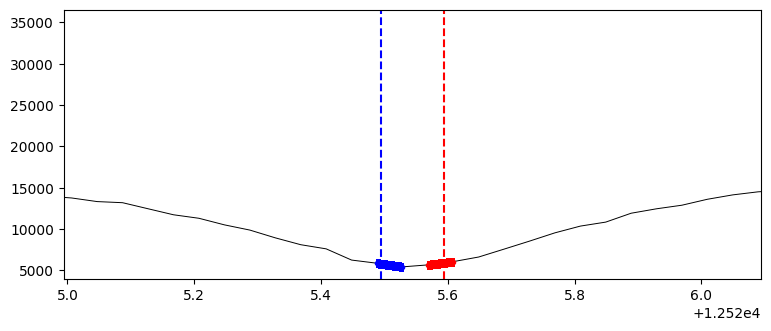

In [ ]:
plt.figure(figsize=(9, 3.5))
plt.plot(wave, flux, 'k-', lw=0.7)
plt.plot(wave_low, array_low, 'b.-')
plt.plot(wave_i_low, array_i_low, 'b|')
plt.axvline(wmin, color='b', ls='--')
plt.plot(wave_high, array_high, 'r.-')
plt.plot(wave_i_high, array_i_high, 'r|')
plt.axvline(wmax, color='r' , ls='--')
plt.xlim(wmin - 0.5, wmax + 0.5)
plt.show()

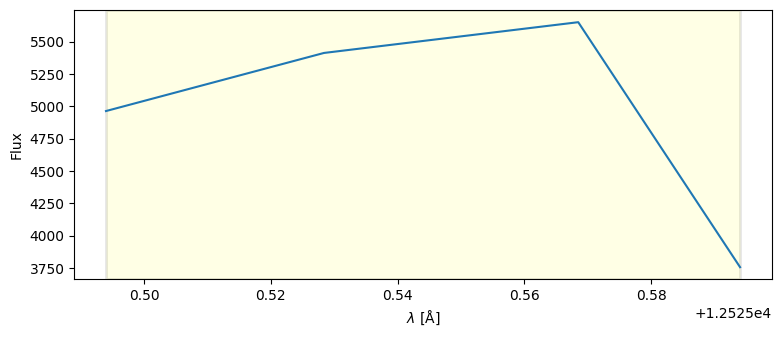

In [ ]:
plt.figure(figsize=(9, 3.5))
plt.errorbar(wave_i, flux_i)
plt.axvspan(ln_ctr - ln_win / 2, ln_ctr + ln_win / 2, alpha=0.1, color='yellow', ec = "black", lw = 2)
plt.xlabel(r"$\lambda$ [Å]")
plt.ylabel("Flux")
plt.show()

In [ ]:
def spec_interpolation_1(wave,flux,flux_error,ln_ctr,interp_win):

        lambda_max = ln_ctr+interp_win/2; lambda_min = ln_ctr-interp_win/2
        mask = (wave >= lambda_min-1) & (wave <= lambda_max+1)    
        wave_win = wave[mask]
        flux_win = flux[mask]
        flux_error_win = flux_error[mask]
        wstep = np.median(np.diff(wave_win))
        n_points = int((lambda_max-lambda_min)/wstep)+1
        x_interp = np.linspace(lambda_min, lambda_max, n_points)

        resampler = SplineInterpolatedResampler()
        spec = Spectrum1D(spectral_axis=wave_win*u.AA, flux=flux_win*u.dimensionless_unscaled, uncertainty=StdDevUncertainty(flux_error_win*u.dimensionless_unscaled))
        spec_re = resampler(spec, x_interp * u.AA)

        return spec_re.wavelength.value, spec_re.flux.value, spec_re.uncertainty.array


for i in tqdm.tqdm(range(1)):
        wave, flux, flux_error, bjd[i] = spectra_observations[i][0], spectra_observations[i][1], spectra_observations[i][2], bjd_observations[i]

        spec_order = AMATERASU._spec_order(wave, ln_ctr, total_win)
        wave, flux, flux_error = wave[spec_order], flux[spec_order], flux_error[spec_order]
        wave_i, flux_i, flux_err_i = spec_interpolation_1(wave,flux,flux_error,ln_ctr,ln_win)

        print(wave_i)
        print(flux_i)
        

100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

[12525.494 12525.544 12525.594]
[5795.51001352 5429.17977747 5900.24908859]


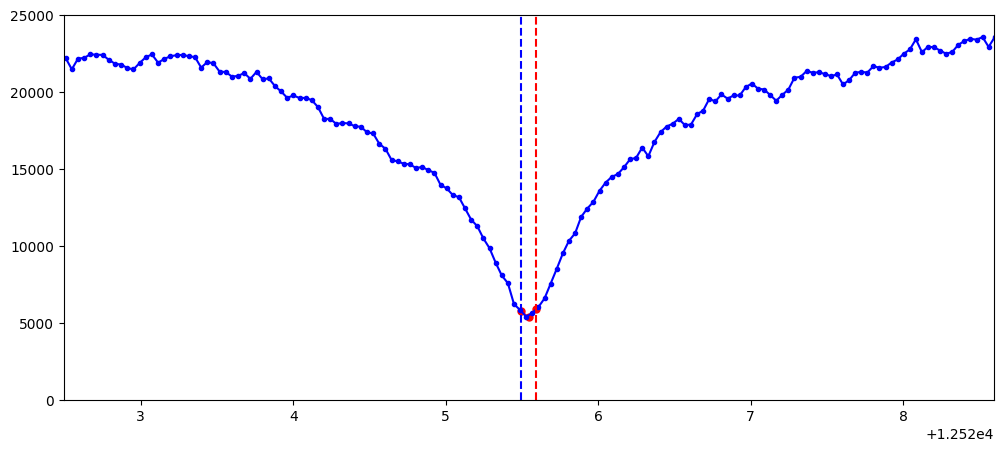

In [ ]:
ln_win = 0.1
wmin = ln_ctr-ln_win/2; wmax = ln_ctr+ln_win/2
plt.figure(figsize=(12, 5))
plt.plot(wave_i, flux_i, 'r.-', lw=0.7, ms=10)
plt.plot(wave, flux, 'b.-')
plt.axvline(wmin, color='b', ls='--')
plt.axvline(wmax, color='r' , ls='--')
plt.xlim(wmin - 3, wmax + 3)
plt.ylim(0,25000)
plt.show()

## Cretignier (2020) method

In [ ]:
i = 0
#wave, flux, flux_error, bjd[i] = spectra_observations[i][0], spectra_observations[i][1], spectra_observations[i][2], bjd_observations[i]

file = f"/home/telmo/Thesis/coadded_2D_spectra/{star}_NIRPS.fits"
with fits.open(file) as hdul:
    wave = hdul[spec_order+1].data[0]
    flux = hdul[spec_order+1].data[1]
    flux_error = hdul[spec_order+1].data[2]

#spec_order = AMATERASU._spec_order(wave, ln_ctr, ln_win)

#wave, flux, flux_error = wave[spec_order], flux[spec_order], flux_error[spec_order]
mask = (wave >= ln_ctr - 5) & (wave <= ln_ctr + 5)

In [ ]:
wave_i = wave[mask]
flux_i = flux[mask]
flux_error_i = flux_error[mask]

flux_i = (flux_i-np.min(flux_i))/(np.max(flux_i)-np.min(flux_i))

In [ ]:
#moving average
N = 10

first_derv = np.gradient(flux_i)
first_derv = np.convolve(first_derv, np.ones(N)/N, mode='same')

second_derv = np.gradient(first_derv)
second_derv = np.convolve(second_derv, np.ones(N)/N, mode='same')

In [ ]:
from scipy.signal import argrelextrema

indices_local_minima_flux = argrelextrema(flux_i, np.less, order=5)[0]
indices_local_maxima_flux = argrelextrema(flux_i, np.greater, order=5)[0]

indices_local_minima_1_derv = argrelextrema(first_derv, np.less,order=5)[0]
indices_local_maxima_1_derv = argrelextrema(first_derv, np.greater,order=5)[0]

indices_local_minima_2_derv = argrelextrema(second_derv, np.less,order=5)[0]
indices_local_maxima_2_derv = argrelextrema(second_derv, np.greater,order=5)[0]

In [ ]:
flux_minima = flux_i[indices_local_minima_flux]
wave_minima = wave_i[indices_local_minima_flux]
flux_maxima = flux_i[indices_local_maxima_flux]
wave_maxima = wave_i[indices_local_maxima_flux]
wave_maxima


array([12520.82624296, 12521.55297714, 12521.89496969, 12522.707202  ,
       12523.17744176, 12527.02485798, 12527.4095996 , 12528.09358471,
       12528.90581702, 12529.54705306, 12530.01729282], dtype='>f8')

In [ ]:
def flux_morphology(wave_i,flux_i):

    indices_local_minima_flux = argrelextrema(flux_i, np.less, order=5)[0]
    indices_local_maxima_flux = argrelextrema(flux_i, np.greater, order=5)[0]

    flux_minima = flux_i[indices_local_minima_flux]
    wave_minima = wave_i[indices_local_minima_flux]
    flux_maxima = flux_i[indices_local_maxima_flux]
    wave_maxima = wave_i[indices_local_maxima_flux]

    #Large Window_i
    LW = np.zeros((len(wave_minima)))
    continuum_difference = np.zeros((len(wave_minima)))
    for i,wave_min in enumerate(wave_minima): #number of lines
        # Find the closest local maxima to the left and right of the current minimum
        right_maxima_index = np.where(wave_maxima > wave_min)[0]
        left_maxima_index = np.where(wave_maxima < wave_min)[0]

        LW[i] = np.min([np.abs(wave_maxima[left_maxima_index[-1]]-wave_min), np.abs(wave_maxima[right_maxima_index[0]]-wave_min)])

        continuum_difference[i] = np.abs(flux_maxima[left_maxima_index[-1]] - flux_maxima[right_maxima_index[0]])
    
    return indices_local_minima_flux, indices_local_maxima_flux, wave_minima, LW, continuum_difference

    

In [ ]:
flux_morphology(wave_i,flux_i)

(array([ 18,  27,  40,  47,  55, 116, 154, 165, 180, 202]),
 array([  6,  23,  31,  50,  61, 151, 160, 176, 195, 210, 221]),
 array([12521.33923179, 12521.72397341, 12522.27971131, 12522.57895479,
        12522.92094735, 12525.52864056, 12527.15310519, 12527.62334495,
        12528.26458098, 12529.2050605 ], dtype='>f8'),
 array([0.21374535, 0.17099628, 0.38474162, 0.12824721, 0.21374535,
        1.49621742, 0.12824721, 0.21374535, 0.17099628, 0.29924348]),
 array([0.05195416, 0.00409857, 0.07949332, 0.07949332, 0.00274116,
        0.12658178, 0.06856974, 0.07129257, 0.06317385, 0.0093952 ]))

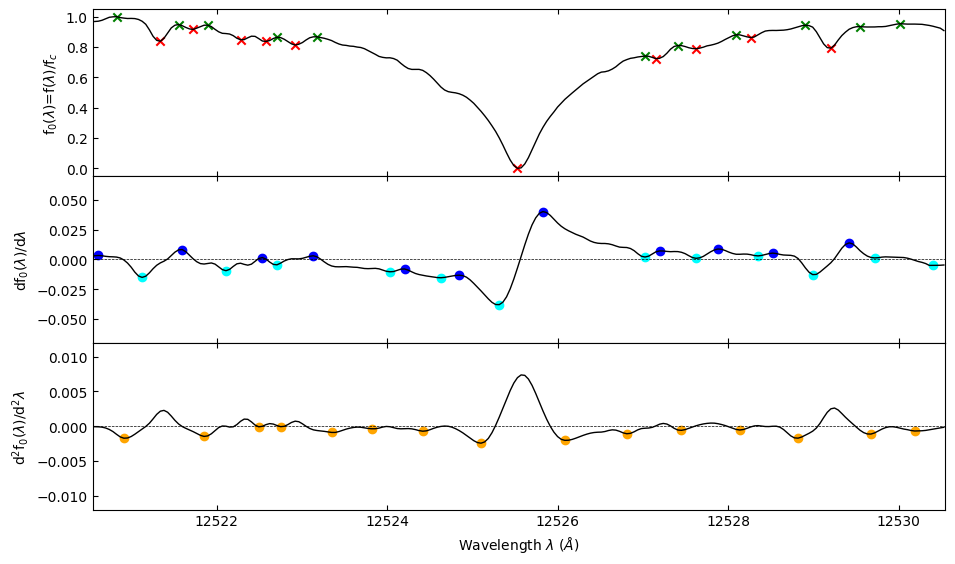

In [ ]:
fig, ax = plt.subplots(nrows=3,figsize=(11,6.5),sharex="col")

ax[0].plot(wave_i,flux_i,'k-', lw=1)
ax[0].scatter(wave_minima,flux_minima,c="red",marker="x")
ax[0].scatter(wave_maxima,flux_maxima,c="green",marker="x")
ax[0].set_ylabel(r"f$_0$($\lambda$)=f($\lambda$)/f$_c$")
ax[0].set_xlim(ln_ctr-5,ln_ctr+5)

ax[1].plot(wave_i,first_derv,'k-', lw=1)
ax[1].scatter(wave_i[indices_local_minima_1_derv],first_derv[indices_local_minima_1_derv],c="cyan")
ax[1].scatter(wave_i[indices_local_maxima_1_derv],first_derv[indices_local_maxima_1_derv],c="blue")
ax[1].set_ylabel(r"df$_0$($\lambda$)/d$\lambda$")
ax[1].set_ylim(-0.07,0.07)
ax[1].set_xlim(ln_ctr-5,ln_ctr+5)
ax[1].axhline(0,ls="--",lw=0.5,c="k")

ax[2].plot(wave_i,second_derv,'k-', lw=1)
ax[2].scatter(wave_i[indices_local_minima_2_derv],second_derv[indices_local_minima_2_derv],c="orange")
#ax[2].scatter(wave_i[indices_local_maxima_2_derv],second_derv[indices_local_maxima_2_derv],c="blue")
ax[2].set_ylabel(r"d$^2$f$_0$($\lambda$)/d$^2\lambda$")
ax[2].set_ylim(-0.012,0.012)
ax[2].set_xlim(ln_ctr-5,ln_ctr+5)
ax[2].axhline(0,ls="--",lw=0.5,c="k")
ax[2].set_xlabel(f"Wavelength $\lambda$ ($\AA$)")


ax[0].tick_params(axis="both", direction="in", top=True, right=False, which='both')
ax[1].tick_params(axis="both", direction="in", top=True, right=False, which='both')
ax[2].tick_params(axis="both", direction="in", top=True, right=False, which='both')
fig.subplots_adjust(hspace=0.0)
plt.show()

## Scipy find_peaks

In [ ]:
file = f"/home/telmo/Thesis/coadded_2D_spectra/{star}_NIRPS.fits"
orders = []
min_dist = []

hdul = fits.open(file)
for i in range(len(hdul)-1):
    
    wave = hdul[i+1].data[0]
    flux = hdul[i+1].data[1]
    flux_error = hdul[i+1].data[2]
    if ln_ctr > wave[0] and ln_ctr < wave[-1]:
        orders.append(i)
        dist = ((ln_ctr - wave[0], wave[-1] - ln_ctr))
        min_dist.append(np.min(dist))

# Selects the order with the higher distance to the wave edges from the bandpass limits:
spec_order = orders[np.argmax(min_dist)]
print(spec_order)

wave = hdul[spec_order+1].data[0]
flux = hdul[spec_order+1].data[1]
flux_error = hdul[spec_order+1].data[2]
hdul.close()

32


In [ ]:
for n in range(spectra_observations.shape[0]):
    orders = []
    min_dist = []
    for i in range(spectra_observations.shape[2]):
        
        wave = spectra_observations[n,0,i,:]
        flux = spectra_observations[n,1,i,:]
        flux_error = spectra_observations[n,2,i,:]
        if ln_ctr > wave[0] and ln_ctr < wave[-1]:
            orders.append(i)
            dist = ((ln_ctr - wave[0], wave[-1] - ln_ctr))
            min_dist.append(np.min(dist))

    spec_order = orders[np.argmax(min_dist)]

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32


In [ ]:
spectra_obs = []
for n in range(spectra_observations.shape[0]): #N_observations
    orders = []
    min_dist = []
    for i in range(spectra_observations.shape[2]): #N_orders
        wave = spectra_observations[n,0,i,:]
        if ln_ctr > wave[0] and ln_ctr < wave[-1]:
            orders.append(i)
            dist = ((ln_ctr - wave[0], wave[-1] - ln_ctr))
            min_dist.append(np.min(dist))

    spec_order = orders[np.argmax(min_dist)]
    spectra_obs.append(spectra_observations[n,:,spec_order,:])

spectra_obs = np.array(spectra_obs, dtype=object) 
spectra_obs.shape

(137, 3, 4084)

In [ ]:
def detect_lines(wave, flux):
    # Invert the flux to turn absorption lines into peaks
    inverted_flux = -flux

    # Find peaks in the inverted flux
    peaks_indices, properties = find_peaks(inverted_flux, rel_height=0.5, width=1)

    # Extract the wavelengths and widths of the detected absorption lines
    lines_center = wave[peaks_indices]
    lines_fwhm = properties['widths'] * np.median(np.diff(wave))

    return peaks_indices, lines_center, lines_fwhm

In [ ]:
peaks_indices, lines_center, lines_fwhm  = detect_lines(wave, flux)

In [ ]:
for i, (wavelength, fwhm, peaks_ind) in enumerate(zip(lines_center, lines_fwhm, peaks_indices)):
    if np.isclose(wavelength,ln_ctr,atol=0.1):
        ln_ctr_new = np.around(wavelength,3)
        ln_fwhm = np.around(fwhm,5)
        ctr_flux = flux[peaks_ind]

print(ln_ctr_new,ln_fwhm, ctr_flux)

12525.529 1.49648 1027797.8725855005


In [ ]:
bp_window = np.around(5*ln_fwhm,1)
interp_window = 2*bp_window

mask_interp = (wave >= ln_ctr_new - interp_window/2) & (wave <= ln_ctr_new + interp_window/2)
flux_interp = flux[mask_interp]
flux_error_interp = flux_error[mask_interp]
wave_interp = wave[mask_interp]

flux_c = np.percentile(np.array(flux_interp, dtype=float)[(np.isnan(np.array(flux_interp, dtype=float))==False)], 90)
flux_c

4737786.12723764

7.5
1.49648


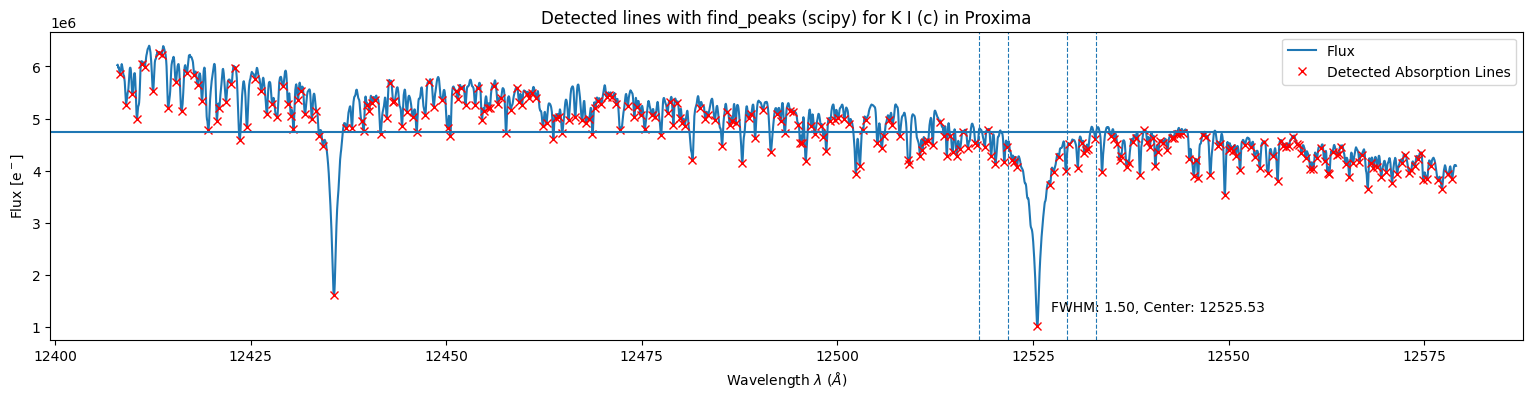

7.5
1.49648


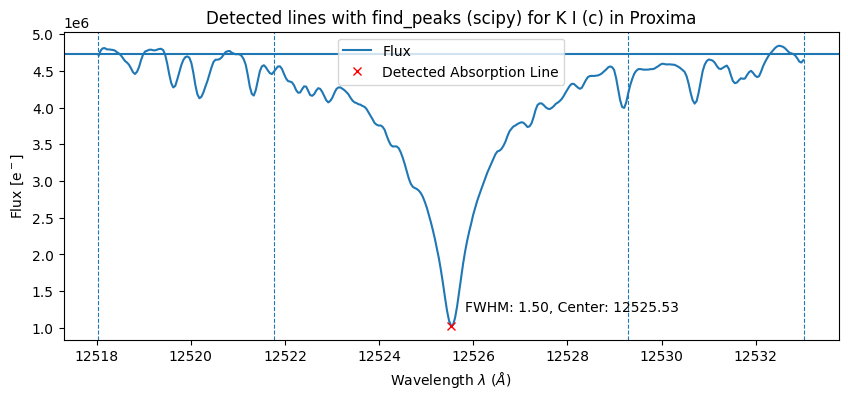

In [ ]:
# Plot the results
plt.figure(figsize=(19, 4))
plt.plot(wave, flux, label='Flux')
plt.plot(wave[peaks_indices], flux[peaks_indices], "x", color="red", label='Detected Absorption Lines')
plt.annotate(f'FWHM: {ln_fwhm:.2f}, Center: {ln_ctr_new:.2f}', xy=(ln_ctr_new, ctr_flux), xytext=(10, 10), textcoords='offset points')
window = np.around(5*ln_fwhm,1)
print(window)
plt.axvline(ln_ctr_new-window/2,lw=0.8,ls="--")
plt.axvline(ln_ctr_new+window/2,lw=0.8,ls="--")
print(ln_fwhm)
plt.axvline(ln_ctr_new-window,lw=0.8,ls="--")
plt.axvline(ln_ctr_new+window,lw=0.8,ls="--")
plt.axhline(flux_c)
plt.xlabel(f"Wavelength $\lambda$ ($\AA$)")
plt.ylabel(r"Flux [e$^-$]")
plt.title('Detected lines with find_peaks (scipy) for K I (c) in Proxima')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(wave_interp, flux_interp, label='Flux')
plt.plot(ln_ctr_new, ctr_flux, "x", color="red", label='Detected Absorption Line')
plt.annotate(f'FWHM: {ln_fwhm:.2f}, Center: {ln_ctr_new:.2f}', xy=(ln_ctr_new, ctr_flux), xytext=(10, 10), textcoords='offset points')
window = np.around(5*ln_fwhm,1)
print(window)
plt.axvline(ln_ctr_new-window/2,lw=0.8,ls="--")
plt.axvline(ln_ctr_new+window/2,lw=0.8,ls="--")
print(ln_fwhm)
plt.axvline(ln_ctr_new-window,lw=0.8,ls="--")
plt.axvline(ln_ctr_new+window,lw=0.8,ls="--")
plt.axhline(flux_c)
plt.xlabel(f"Wavelength $\lambda$ ($\AA$)")
plt.ylabel(r"Flux [e$^-$]")
plt.title('Detected lines with find_peaks (scipy) for K I (c) in Proxima')
plt.legend()
plt.show()

## Running AMATERASU

In [ ]:
star = "GJ551"

indice = ["KIb","KIc"]

period_test = [85,15]
ptol = 0.15*period_test[0]
fap_treshold = 0.001

indice_info = {'ln_ctr':12525.544}

amaterasu = AMATERASU(star, bjd_observations, spectra_observations, period_test, ptol, fap_treshold, indice, interp=True, indice_info=indice_info, folder_path="amaterasu_tests")

AMATERASU instance created for GJ551
Computing KIb EWs for 137 spectra.


100%|██████████| 137/137 [00:21<00:00,  6.34it/s]


Computing GLS Periodograms.


  2%|▏         | 1/60 [00:01<01:13,  1.25s/it]

Bandpass of 0.1 A with period = 79.472 d and FAP 3.461090618761231e-17%


  3%|▎         | 2/60 [00:02<01:04,  1.10s/it]

Bandpass of 0.2 A with period = 79.895 d and FAP 1.0078299789232563e-14%


  5%|▌         | 3/60 [00:03<01:00,  1.06s/it]

Bandpass of 0.3 A with period = 80.753 d and FAP 4.066975872671349e-08%


 10%|█         | 6/60 [00:06<00:57,  1.06s/it]

Bandpass of 0.6 A with period = 77.427 d and FAP 0.0006086641699232816%


 12%|█▏        | 7/60 [00:07<00:52,  1.01it/s]

Bandpass of 0.7 A with period = 78.232 d and FAP 3.861974108618005e-07%


 13%|█▎        | 8/60 [00:08<00:49,  1.05it/s]

Bandpass of 0.8 A with period = 78.641 d and FAP 1.4976527014702597e-09%


 15%|█▌        | 9/60 [00:09<00:47,  1.07it/s]

Bandpass of 0.9 A with period = 78.641 d and FAP 8.113172173061434e-12%


 17%|█▋        | 10/60 [00:09<00:46,  1.09it/s]

Bandpass of 1.0 A with period = 78.641 d and FAP 2.7495798317065933e-13%


 18%|█▊        | 11/60 [00:10<00:44,  1.10it/s]

Bandpass of 1.1 A with period = 78.641 d and FAP 7.249659158881992e-15%


 20%|██        | 12/60 [00:11<00:43,  1.10it/s]

Bandpass of 1.2 A with period = 78.641 d and FAP 6.207905840200621e-15%


 22%|██▏       | 13/60 [00:12<00:42,  1.10it/s]

Bandpass of 1.3 A with period = 78.641 d and FAP 8.222422630153584e-15%


 23%|██▎       | 14/60 [00:13<00:42,  1.09it/s]

Bandpass of 1.4 A with period = 79.055 d and FAP 1.0103016544821698e-14%


 25%|██▌       | 15/60 [00:14<00:41,  1.09it/s]

Bandpass of 1.5 A with period = 78.641 d and FAP 1.5677135089443242e-15%


 27%|██▋       | 16/60 [00:15<00:41,  1.07it/s]

Bandpass of 1.6 A with period = 79.055 d and FAP 6.09977490569715e-17%


 28%|██▊       | 17/60 [00:16<00:40,  1.06it/s]

Bandpass of 1.7 A with period = 79.055 d and FAP 3.188619849017116e-17%


 30%|███       | 18/60 [00:17<00:40,  1.04it/s]

Bandpass of 1.8 A with period = 79.055 d and FAP 3.159783245624586e-17%


 32%|███▏      | 19/60 [00:18<00:39,  1.03it/s]

Bandpass of 1.9 A with period = 79.055 d and FAP 7.294901943131197e-17%


 33%|███▎      | 20/60 [00:19<00:39,  1.03it/s]

Bandpass of 2.0 A with period = 79.055 d and FAP 2.6167756183261963e-17%


 35%|███▌      | 21/60 [00:20<00:38,  1.01it/s]

Bandpass of 2.1 A with period = 79.055 d and FAP 2.4569236839030824e-17%


 37%|███▋      | 22/60 [00:21<00:37,  1.00it/s]

Bandpass of 2.2 A with period = 79.055 d and FAP 7.844360886306316e-17%


 38%|███▊      | 23/60 [00:22<00:37,  1.01s/it]

Bandpass of 2.3 A with period = 79.055 d and FAP 7.81384755871989e-17%


 40%|████      | 24/60 [00:23<00:36,  1.02s/it]

Bandpass of 2.4 A with period = 79.055 d and FAP 7.174922619984168e-17%


 42%|████▏     | 25/60 [00:24<00:36,  1.03s/it]

Bandpass of 2.5 A with period = 79.472 d and FAP 6.903990194511555e-17%


 43%|████▎     | 26/60 [00:25<00:35,  1.05s/it]

Bandpass of 2.6 A with period = 79.472 d and FAP 6.532557954907064e-17%


 45%|████▌     | 27/60 [00:26<00:35,  1.08s/it]

Bandpass of 2.7 A with period = 79.472 d and FAP 1.0017558543215016e-16%


 47%|████▋     | 28/60 [00:27<00:34,  1.09s/it]

Bandpass of 2.8 A with period = 79.472 d and FAP 1.0079521168489429e-16%


 48%|████▊     | 29/60 [00:29<00:34,  1.10s/it]

Bandpass of 2.9 A with period = 79.055 d and FAP 1.9761101755158126e-16%


 50%|█████     | 30/60 [00:30<00:34,  1.14s/it]

Bandpass of 3.0 A with period = 79.055 d and FAP 2.9332250965679945e-16%


 52%|█████▏    | 31/60 [00:31<00:33,  1.16s/it]

Bandpass of 3.1 A with period = 79.055 d and FAP 4.841629066666874e-16%


 53%|█████▎    | 32/60 [00:32<00:32,  1.18s/it]

Bandpass of 3.2 A with period = 79.055 d and FAP 9.45879246865015e-16%


 55%|█████▌    | 33/60 [00:33<00:32,  1.20s/it]

Bandpass of 3.3 A with period = 79.055 d and FAP 3.253977548167295e-15%


 57%|█████▋    | 34/60 [00:35<00:33,  1.28s/it]

Bandpass of 3.4 A with period = 79.055 d and FAP 5.73688999358932e-15%


 58%|█████▊    | 35/60 [00:36<00:32,  1.30s/it]

Bandpass of 3.5 A with period = 79.055 d and FAP 6.1390193208702306e-15%


 60%|██████    | 36/60 [00:38<00:31,  1.31s/it]

Bandpass of 3.6 A with period = 79.055 d and FAP 1.7881097149130298e-14%


 62%|██████▏   | 37/60 [00:39<00:30,  1.32s/it]

Bandpass of 3.7 A with period = 79.055 d and FAP 3.307257577088514e-14%


 63%|██████▎   | 38/60 [00:40<00:29,  1.35s/it]

Bandpass of 3.8 A with period = 79.055 d and FAP 4.207993263215309e-15%


 65%|██████▌   | 39/60 [00:42<00:28,  1.35s/it]

Bandpass of 3.9 A with period = 79.055 d and FAP 1.8453026199540029e-13%


 67%|██████▋   | 40/60 [00:43<00:26,  1.35s/it]

Bandpass of 4.0 A with period = 79.055 d and FAP 7.300628845487579e-14%


 68%|██████▊   | 41/60 [00:44<00:25,  1.36s/it]

Bandpass of 4.1 A with period = 79.055 d and FAP 1.611729233078678e-14%


 70%|███████   | 42/60 [00:46<00:26,  1.46s/it]

Bandpass of 4.2 A with period = 79.472 d and FAP 4.862070529714814e-14%


 72%|███████▏  | 43/60 [00:47<00:24,  1.42s/it]

Bandpass of 4.3 A with period = 79.472 d and FAP 7.832038384403876e-14%


 73%|███████▎  | 44/60 [00:49<00:22,  1.39s/it]

Bandpass of 4.4 A with period = 79.472 d and FAP 1.542722061039114e-13%


 75%|███████▌  | 45/60 [00:50<00:21,  1.44s/it]

Bandpass of 4.5 A with period = 79.472 d and FAP 1.3176831474108795e-12%


 77%|███████▋  | 46/60 [00:52<00:20,  1.44s/it]

Bandpass of 4.6 A with period = 79.472 d and FAP 7.385355335878052e-13%


 78%|███████▊  | 47/60 [00:53<00:18,  1.44s/it]

Bandpass of 4.7 A with period = 79.472 d and FAP 4.0126762088624066e-11%


 80%|████████  | 48/60 [00:55<00:17,  1.44s/it]

Bandpass of 4.8 A with period = 79.472 d and FAP 1.6622288452096075e-12%


 82%|████████▏ | 49/60 [00:56<00:16,  1.48s/it]

Bandpass of 4.9 A with period = 79.472 d and FAP 7.14423452819707e-11%


 83%|████████▎ | 50/60 [00:58<00:14,  1.49s/it]

Bandpass of 5.0 A with period = 79.472 d and FAP 3.5985173891279116e-12%


 85%|████████▌ | 51/60 [00:59<00:13,  1.50s/it]

Bandpass of 5.1 A with period = 79.472 d and FAP 1.272892368189596e-10%


 87%|████████▋ | 52/60 [01:01<00:11,  1.50s/it]

Bandpass of 5.2 A with period = 79.472 d and FAP 1.8387879615487602e-10%


 88%|████████▊ | 53/60 [01:02<00:10,  1.56s/it]

Bandpass of 5.3 A with period = 79.472 d and FAP 7.386048297210608e-10%


 90%|█████████ | 54/60 [01:04<00:09,  1.60s/it]

Bandpass of 5.4 A with period = 79.472 d and FAP 3.4883525453946242e-09%


 92%|█████████▏| 55/60 [01:06<00:08,  1.62s/it]

Bandpass of 5.5 A with period = 79.472 d and FAP 7.1636424878086125e-09%


 93%|█████████▎| 56/60 [01:08<00:06,  1.65s/it]

Bandpass of 5.6 A with period = 79.472 d and FAP 1.7185871784141424e-08%


 95%|█████████▌| 57/60 [01:09<00:05,  1.68s/it]

Bandpass of 5.7 A with period = 79.472 d and FAP 3.126669639336297e-08%


 97%|█████████▋| 58/60 [01:11<00:03,  1.77s/it]

Bandpass of 5.8 A with period = 79.472 d and FAP 5.404426998623755e-08%


 98%|█████████▊| 59/60 [01:14<00:02,  2.17s/it]

Bandpass of 5.9 A with period = 79.472 d and FAP 7.576035188429481e-08%


As we can see, K I (c) is able to detect GJ 581's rotation period quite nicely for bandpasses over 0.9 $\AA$. Let's check which bandpasses catched the input period:

In [5]:
AMATERASU.periods_flagged

,bandpass,period,flag_period,fap_best
0,0.1,79.472,3,3.461091e-19
1,0.2,79.895,3,1.007830e-16
2,0.3,80.753,3,4.066976e-10
3,0.6,77.427,3,6.086642e-06
4,0.7,78.232,3,3.861974e-09
5,0.8,78.641,3,1.497653e-11
6,0.9,78.641,3,8.113172e-14
7,1.0,78.641,3,2.749580e-15
8,1.1,78.641,3,7.249659e-17
9,1.2,78.641,3,6.207906e-17


Let's do a nice plot of the GLS periodograms for all bandpasses computed.

Mg I line at 11831.408 A is capable of detecting Prot of Proxima with bandpasses of 0.1, 0.2 and 0.3

100%|██████████| 60/60 [00:00<00:00, 74.30it/s]


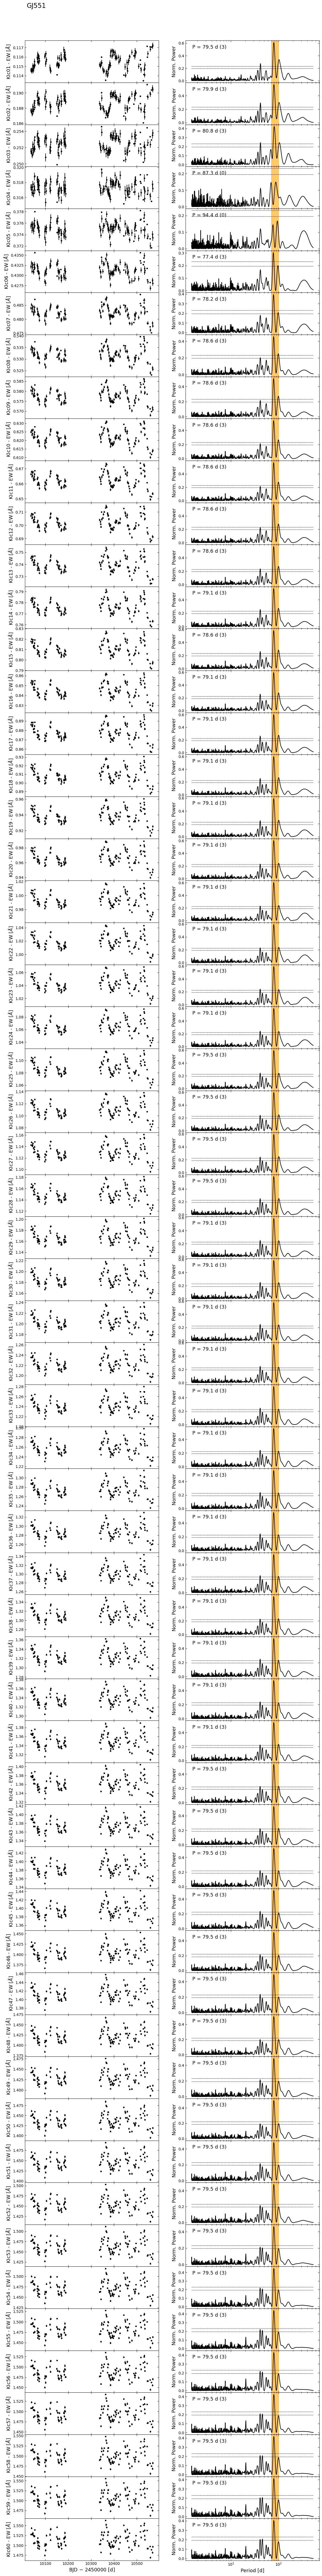

In [6]:
#p_rot_lit_list = [[132.5,6.3],[141.6,3.5],[130,2]] #different literature values
p_rot_lit_list = [[85,15]]

AMATERASU.GLS_plot(star, indice, p_rot_lit_list, AMATERASU.ew_cols, AMATERASU.EWs, AMATERASU.gls_results_all, folder="")
plt.show()

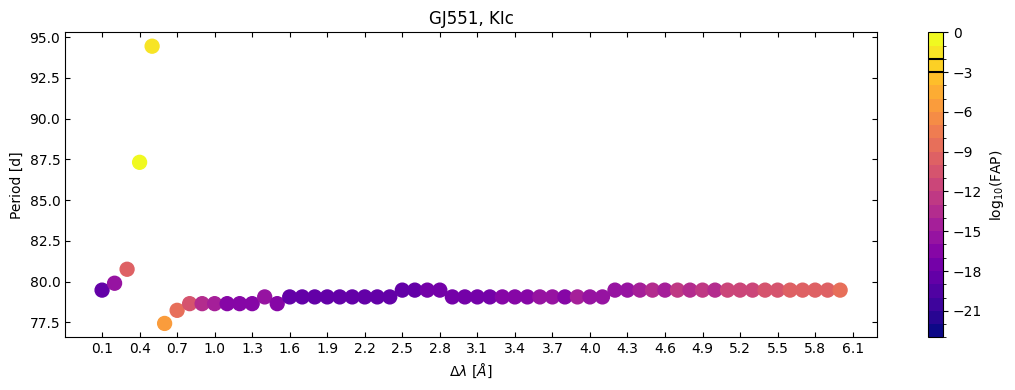

: 

In [ ]:
df_gls = AMATERASU.gls_results

import matplotlib.colors as mcolors # type: ignore

cmap = plt.get_cmap("plasma")
log_FAP_min, log_FAP_max = 0, -23
boundaries = np.arange(log_FAP_max, log_FAP_min + 1, 1)  # Intervals of 1
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(11, 4))

axes.set_title(f"{star}, {indice}")
sc1 = axes.scatter(df_gls["bandpass"], df_gls["period"], c=np.log10(df_gls["fap_best"]), cmap=cmap, marker="o", s=100, norm=norm)

axes.set_xlabel(r"$\Delta \lambda$ [$\AA$]"); axes.set_ylabel(r"Period [d]")
cbar = fig.colorbar(sc1, ax=axes, label=r"log$_{10}$(FAP)")
cbar.ax.axhline(y=np.log10(0.001), color='black', linestyle="-", linewidth=1.5)
cbar.ax.axhline(y=np.log10(0.01), color='black', linestyle="-", linewidth=1.5)

axes.set_xticks(np.arange(df_gls["bandpass"].min(),df_gls["bandpass"].max()+0.3,0.3))

axes.tick_params(axis="both", direction="in", top=True, right=True, which="both")
plt.tight_layout()
plt.show()

We can also visualize a single spectral line, if we wish.

In [ ]:
amaterasu = AMATERASU(star, bjd_observations, spectra_observations, period_test, ptol, fap_treshold, indice, run_gls=False, plot_line=True)